# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf). 

Link to help create a table of contents is [here](https://sebastianraschka.com/Articles/2014_ipython_internal_links.html).

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sleep Sensitivity
In this notebook we take a look at the variables that might be affecting sleep the most.

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
    1. [Labels](#labels)
    2. [Features](#features)
        1. Complete
        2. IEQ
        3. Mood
        4. Self-Report Sleep
        5. Fitbit Activity
2. [Analysis](#analysis)
    1. [Feature Engineering](#feature_engineering)
        1. [Mutual Information](#mutual_information)

<a id='data_import'></a>

# Data Import
We have a spate of data available to us from the three main modalities: beacon, Fitbit, and Beiwe. Each of these datasets can be analyzed individually or all together. Each of these datasets has already been created via the `build_features` source code.

<a id='labels'></a>

## Labels
We can start by importing the labels dataset: Fitbit sleep metrics.

In [3]:
labels = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
labels.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,duration_ms,efficiency,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,time_in_bed,redcap,beacon
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3.109000e+03,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,2950.000000,1724.000000
mean,3.732711,77.101962,28.256031,243.267289,9.386619,86.384690,30.306208,63.342232,2.820577e+07,91.695722,1.205211,406.753940,63.342232,0.038598,470.096172,40.865763,21.473898
std,1.468774,25.795931,8.626905,55.887225,4.294173,30.717377,9.232387,19.729932,5.488601e+06,8.480847,3.976648,79.127519,19.729932,0.812817,91.476682,21.837114,11.936372
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,1.092000e+07,27.000000,0.000000,153.000000,14.000000,0.000000,182.000000,0.000000,1.000000
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,2.520000e+07,91.000000,0.000000,362.000000,50.000000,0.000000,420.000000,23.000000,13.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,87.000000,30.000000,62.000000,2.844000e+07,93.000000,0.000000,409.000000,62.000000,0.000000,474.000000,45.000000,21.000000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,107.000000,36.000000,75.000000,3.162000e+07,96.000000,0.000000,456.000000,75.000000,0.000000,527.000000,56.000000,29.000000
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,66.000000,174.000000,6.366000e+07,100.000000,53.000000,887.000000,174.000000,28.000000,1061.000000,87.000000,46.000000


<a id='features'></a>

## Features
Next we can import the various datasets that can be used for the features. We start with the most complete dataset and trickle down from there.

### Complete Features Dataset
This dataset, while short, is the most comprehensive and includes overlapping data from all modalities.

In [4]:
features_complete = pd.read_csv("../data/processed/all_modalities-fb_and_gps_filtered-ux_s20.csv",parse_dates=["start_time","end_time"])
features_complete.describe()

,lat_mean,long_mean,altitude_mean,accuracy_mean,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,lat_median,long_median,altitude_median,accuracy_median,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,lat_delta,long_delta,altitude_delta,accuracy_delta,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,lat_delta_percent,long_delta_percent,altitude_delta_percent,accuracy_delta_percent,tvoc_delta_percent,lux_delta_percent,no2_delta_percent,co_delta_percent,co2_delta_percent,pm1_number_delta_percent,pm2p5_number_delta_percent,pm10_number_delta_percent,pm1_mass_delta_percent,pm2p5_mass_delta_percent,pm10_mass_delta_percent,temperature_c_delta_percent,rh_delta_percent,content_morning,stress_morning,lonely_morning,sad_morning,energy_morning,tst,sol,naw,restful,content_evening,stress_evening,lonely_evening,sad_evening,energy_evening,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,duration_ms,efficiency,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,time_in_bed
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,15.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,31.708245,-97.281673,183.152029,226.326105,251.450812,2.584985,1.040589,2.675229,1005.861635,6.940623,7.297195,7.339740,0.529240,1.264329,2.180827,26.794703,42.677904,21.826087,28.521739,44.000000,31.708215,-97.281549,183.926963,46.372968,251.636715,2.134963,1.068903,2.598729,1002.601932,6.641631,7.035111,7.086057,0.513637,1.251939,2.169061,26.755616,42.614130,0.002767,0.005028,9.797499,2762.532037,145.283333,7.662299,0.216908,1.548383,231.177142,8.077241,8.590784,8.665080,0.561023,0.988647,1.018249,1.450725,3.604710,0.008496,-0.005184,6.285770,51440.372741,inf,inf,-53.704067,127.955648,29.344919,1091.017982,3660.212034,2481.321599,395.931490,117.457011,58.275877,5.728423,8.640482,2.347826,0.695652,0.130435,0.086957,2.391304,6.760870,13.173913,1.782609,2.130435,2.347826,0.521739,0.217391,0.086957,2.478261,2168.956522,7594.739130,3.272456,706.434783,187.826087,16.695652,25.391304,874.260870,3.826087,74.695652,28.043478,247.695652,8.434783,78.913043,29.521739,63.347826,2.787913e+07,93.173913,0.347826,401.304348,63.347826,0.478261,464.652174
std,1.406060,0.400138,17.965757,196.406064,86.479202,6.985300,0.146838,2.892325,305.096311,4.755816,4.742392,4.693987,0.302098,0.299442,0.230945,2.134758,5.469532,10.002964,12.090077,18.466185,1.406037,0.400200,17.193880,23.869096,88.165647,6.447158,0.208614,2.890972,3

### IEQ Features Dataset
Arguably the most restrictive dataset after the complete set, we can import the IEQ features from the beacon.

In [5]:
features_ieq = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
features_ieq.describe()

,lat_mean,long_mean,altitude_mean,accuracy_mean,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,lat_median,long_median,altitude_median,accuracy_median,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,lat_delta,long_delta,altitude_delta,accuracy_delta,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,lat_delta_percent,long_delta_percent,altitude_delta_percent,accuracy_delta_percent,tvoc_delta_percent,lux_delta_percent,no2_delta_percent,co_delta_percent,co2_delta_percent,pm1_number_delta_percent,pm2p5_number_delta_percent,pm10_number_delta_percent,pm1_mass_delta_percent,pm2p5_mass_delta_percent,pm10_mass_delta_percent,temperature_c_delta_percent,rh_delta_percent
count,226.000000,226.000000,226.000000,226.000000,225.000000,224.000000,120.000000,226.000000,226.000000,212.000000,212.000000,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,225.000000,224.000000,120.000000,226.000000,226.000000,212.000000,212.000000,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,225.000000,224.000000,120.000000,226.000000,226.000000,212.000000,212.000000,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,225.000000,171.000000,120.000000,226.000000,226.000000,2.120000e+02,2.120000e+02,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000
mean,31.629575,-97.223753,182.485283,194.578042,265.534761,3.332562,1.079495,2.609954,969.410538,8.507479,8.825611,8.851313,0.619491,1.346435,2.124992,26.944455,42.659180,23.561947,30.592920,43.292035,31.629524,-97.223647,182.709338,57.819205,261.623444,2.696463,1.079890,2.580662,966.848844,8.073657,8.413720,8.438968,0.593751,1.321277,2.107642,26.947087,42.587525,0.003137,0.003752,11.822930,1777.088363,167.211975,9.025819,0.122769,1.106574,194.775597,9.720924,10.125966,10.170523,0.648698,1.064177,0.998584,1.277028,3.288397,0.009635,-0.003867,7.688277,33558.960860,inf,inf,4.114170,54.221409,22.092101,1.949969e+05,1.518557e+04,9279.687057,780.383287,122.637226,56.102260,5.000845,7.908389
std,1.362328,0.591867,29.627050,244.599722,144.383798,7.050839,0.326953,2.614681,376.737318,9.678663,9.429568,9.290298,0.595378,0.558059,0.606684,1.907365,5.569048,10.776030,11.793887,16.737812,1.362234,0.591890,29.404338,188.887815,142.637621,6.958426,0.327470,2.597982,377.358531,9.102868,8.905938,8.795275,0.562893,0.538596,0.600255,1.919237,5.480965,0.005116,0.006124,21.567844,2240.033171,163.335493,14.431962,0.206673,1.497328,161.792600,14.050166,13.385237,13.141243,0.867057,0.847131,0.813763,0.775867,2.283233,0.015479,0.006315,15.428924,45343.121159,NaN,NaN,66.854270,285.667824,17.209670,2.001081e+06,8.221712e+04,62619.940045,2386.167281,89.571312,46.607221,3.243378,5.079784
min,30.280130,-97.751836,63.792565,4.742241,19.016547,0.000000,-0.276564,-0.031249,421.230566,0.116044,0.469432,0.598738,0.088306,0.654342,0.546604,23.000000,31.449031,1.000000,9.000000,10.000000,30.280140,-97.751800,63.792565,4.742545,9.500000,0.000000,-0.276482,-0.038750,419.238070,0.116044,0.469432,0.598738,0.080327,0.654342,0.546604,23.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.024904,0.000000,0.000000,0.000000,0.000000,-713.396648,-1301.118454,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.357352,-97.644297,175.716933,32.119923,193.786395,0.

### Self-Report Mood Features Dataset
A more complex relationship

In [6]:
features_mood = pd.read_csv("../data/processed/beiwe_fitbit-evening_mood_and_sleep-ux_s20.csv",parse_dates=["start_date","end_date","start_time","end_time"])
features_mood.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,duration_ms,efficiency,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,time_in_bed,redcap,beacon,content,stress,lonely,sad,energy
count,641.000000,641.000000,641.00000,641.000000,641.000000,641.000000,641.000000,641.000000,6.410000e+02,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,474.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,3.594384,74.964119,28.74883,247.928237,9.099844,87.430577,30.393136,64.536661,2.849158e+07,92.427457,1.257410,410.322933,64.536661,0.040562,474.859594,40.783151,20.556962,2.156006,0.811232,0.575663,0.408736,2.031201
std,1.442946,25.062926,9.04542,56.491076,4.300002,32.056814,9.371243,19.464687,5.460182e+06,7.952680,4.175922,78.736727,19.464687,0.734151,91.003034,20.435908,10.027548,0.833291,0.892818,0.827817,0.750948,1.086405
min,1.000000,6.000000,4.00000,51.000000,0.000000,0.000000,5.000000,14.000000,1.200000e+07,27.000000,0.000000,164.000000,14.000000,0.000000,200.000000,0.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,2.000000,58.000000,23.00000,212.000000,6.000000,65.000000,25.000000,52.000000,2.520000e+07,91.000000,0.000000,364.000000,52.000000,0.000000,420.000000,23.000000,13.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,4.000000,76.000000,28.00000,247.000000,9.000000,88.000000,30.000000,63.000000,2.892000e+07,94.000000,0.000000,417.000000,63.000000,0.000000,482.000000,42.000000,21.000000,2.000000,1.000000,0.000000,0.000000,2.000000
75%,4.000000,92.000000,34.00000,284.000000,12.000000,110.000000,36.000000,75.000000,3.210000e+07,96.000000,1.000000,461.000000,75.000000,0.000000,535.000000,58.000000,27.250000,3.000000,1.000000,1.000000,1.000000,3.000000
max,9.000000,148.000000,64.00000,426.000000,28.000000,209.000000,66.000000,136.000000,5.274000e+07,100.000000,53.000000,749.000000,136.000000,15.000000,879.000000,86.000000,44.000000,3.000000,3.000000,3.000000,3.000000,4.000000


### Self-Report Sleep Metric (SRSM) Features Dataset
The feature set that should have the greatest relationship with the Fitbit since it is another measure of sleep quality. 

In [7]:
features_srsm = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_srsm.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,tst_fb,efficiency,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,time_in_bed,redcap,beacon,tst_ema,sol_ema,naw_ema,restful_ema
count,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,683.000000,933.000000,933.000000,933.000000,933.000000
mean,3.648446,75.468382,28.394427,246.593783,9.248660,85.070740,30.309753,62.345123,7.824634,92.125402,1.120043,407.132905,62.345123,0.052519,469.478028,40.131833,20.793558,6.929636,18.329582,1.730975,1.979636
std,1.396151,25.213984,8.386253,55.837700,4.465931,30.995489,9.009621,18.854846,1.498144,8.116661,4.146791,78.278031,18.854846,0.915078,89.888610,20.149569,11.271892,1.340100,21.023896,1.704411,0.827772
min,0.000000,0.000000,7.000000,87.000000,0.000000,0.000000,5.000000,14.000000,3.033333,27.000000,0.000000,159.000000,14.000000,0.000000,182.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.000000,60.000000,23.000000,210.000000,6.000000,64.000000,25.000000,50.000000,6.950000,91.000000,0.000000,361.000000,50.000000,0.000000,417.000000,27.000000,13.000000,6.000000,6.000000,1.000000,2.000000
50%,4.000000,76.000000,28.000000,244.000000,9.000000,85.000000,30.000000,61.000000,7.866667,94.000000,0.000000,409.000000,61.000000,0.000000,472.000000,42.000000,21.000000,7.000000,15.000000,2.000000,2.000000
75%,4.000000,91.000000,34.000000,281.000000,12.000000,106.000000,36.000000,73.000000,8.766667,96.000000,0.000000,455.000000,73.000000,0.000000,526.000000,58.000000,29.000000,8.000000,20.000000,2.000000,3.000000
max,9.000000,148.000000,61.000000,458.000000,24.000000,209.000000,63.000000,145.000000,14.650000,100.000000,53.000000,749.000000,145.000000,22.000000,879.000000,85.000000,44.000000,12.000000,240.000000,15.000000,3.000000


### Fitbit Activity Features Dataset
The largest and final features set is the activity data from Fitbit which should be the closest match to all Fitbit sleep data we have since both are collected from the same source.

In [8]:
features_activity = pd.read_csv("../data/processed/fitbit_fitbit-daily_activity_and_sleep-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_activity.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,duration_ms,efficiency,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,time_in_bed,redcap,beacon,calories,bmr,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,fat,weight,food_calories_logged,water_logged
count,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3.002000e+03,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,2843.000000,1654.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000
mean,3.734177,77.019987,28.243171,242.986009,9.387075,86.241839,30.301799,63.497335,2.818471e+07,91.736842,1.187209,406.247835,63.497335,0.039973,469.745170,40.992613,21.375453,2170.781479,1429.503997,7445.032978,3.262410,744.418388,206.360426,16.420386,20.581945,902.806462,22.289431,1.664820,134.761209,105.276149,1.852765
std,1.469888,25.776219,8.597763,55.765305,4.307345,30.854521,9.217585,19.717114,5.490056e+06,8.375837,3.926040,79.070179,19.717114,0.827148,91.500939,21.792209,11.847433,523.857979,202.346895,5340.182326,2.471111,192.580767,98.976801,25.485015,30.894012,514.843061,2.943300,6.031096,22.517273,441.928007,10.833245
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,1.092000e+07,27.000000,0.000000,153.000000,14.000000,0.000000,182.000000,0.000000,1.000000,1049.000000,1046.000000,4.000000,0.001616,0.000000,0.000000,0.000000,0.000000,0.000000,18.037397,0.000000,96.990000,0.000000,0.000000
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,2.520000e+07,91.000000,0.000000,362.000000,50.000000,0.000000,420.000000,23.000000,13.000000,1807.250000,1255.000000,3482.250000,1.451195,633.000000,141.000000,0.000000,0.000000,533.000000,20.312498,0.000000,118.000000,0.000000,0.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,86.000000,30.000000,62.000000,2.838000e+07,93.000000,0.000000,408.000000,62.000000,0.000000,473.000000,45.000000,21.000000,2097.000000,1365.000000,6226.500000,2.658468,729.000000,194.000000,7.000000,5.000000,818.500000,21.659504,0.000000,130.000000,0.000000,0.000000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,106.000000,36.000000,75.000000,3.162000e+07,96.000000,0.000000,455.000000,75.000000,0.000000,527.000000,58.000000,29.000000,2448.000000,1551.000000,10177.250000,4.504787,820.000000,257.000000,21.000000,33.000000,1171.750000,24.274609,0.000000,140.000000,0.000000,0.000000
max,10.000000,177.000000,61.000000,598.000000,28.000000,219.000000,64.000000,174.000000,6.366000e+07,100.000000,53.000000,887.000000,174.000000,28.000000,1061.000000,87.000000,46.000000,5437.000000,1910.000000,37485.000000,17.323717,1440.000000,636.000000,198.000000,275.000000,4242.000000,31.822655,25.224001,193.600000,3054.000000,120.000000


<a id='analysis'></a>

# Analysis
The analysis section is outlined as followed:

- [Feature Engineering](#feature_engineering)

Much of this code has been refractured into the `build_features` source code and we import that module below so that we can simplify the code presented in this notebook.

In [9]:
import sys
sys.path.append('../')

%load_ext autoreload

%autoreload 2

from src.features import build_features

<a id='feature_engineering'></a>

## Feature Engineering
We follow along some basic guidelines that are outlined in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course on [Kaggle](https://www.kaggle.com). The general outline is given as follows:

- [Mutual Information](#mutual_information)

<a id='mutual_information'></a>

In [10]:
# defining feature engineering object
fe = build_features.feature_engineering()

### Mutual Information
Using mutual information, we can get an initial insight into which features relate most closely with the sleep metric targets from Fitbit. This analysis only compares one feature to the target, but there might be more underlying relationships which we can explore further in later sections.

The first step is determine which features we want to include and which target we are interested in.

In [11]:
# defining
dataset = features_activity
features = ["calories","steps","very_active_minutes"]
target = ["efficiency"]
# getting data
X, y = fe.get_datasets(original_dataset=dataset,feature_labels=features,target_labels=target)

Categorical Variables:
	beiwe
	timestamp


Now we can get the Mutual Information (MI) scores for each of the features we are interested in.

In [15]:
mi_scores = fe.get_mi_scores(X, y)

Now we can visually inspect the MI scores for each of the features in question.

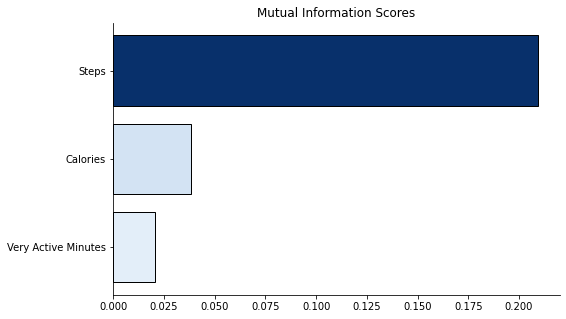

In [16]:
fe.plot_mi_scores(mi_scores)

The MI scores don't tell us what type of relationship, but we can examine it more by looking at a scatter plot of the values.

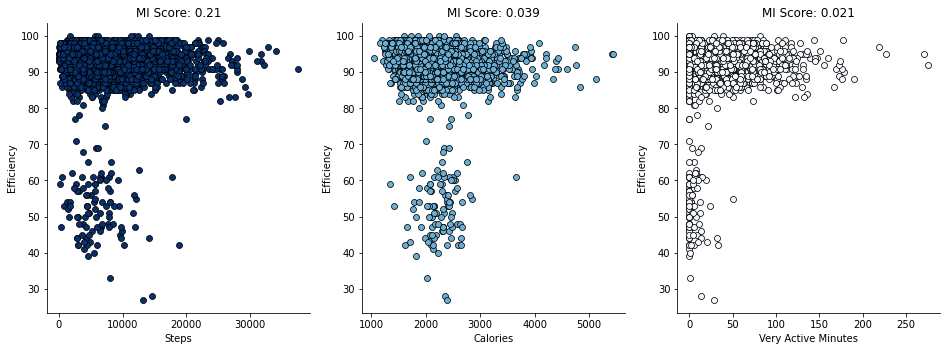

In [17]:
fe.plot_high_scoring_relationships(X, y, mi_scores, num_scores=3, width=16)